In [1]:
import fiftyone as fo
import fiftyone.zoo as foz

dataset = foz.load_zoo_dataset(
    "coco-2017",
    split="validation",
    dataset_name="detector-recipe",
)

Migrating database to v0.15.0.1
 100% |██████████████████████████████████████████████|    1.9Gb/1.9Gb [24.8s elapsed, 0s remaining, 88.7Mb/s]      
Extracting annotations to 'C:\Users\01149762\fiftyone\coco-2017\raw\instances_val2017.json'
 100% |██████████████████████████████████████████████|    6.1Gb/6.1Gb [1.5m elapsed, 0s remaining, 76.1Mb/s]       
Extracting images to 'C:\Users\01149762\fiftyone\coco-2017\validation\data'
Writing annotations to 'C:\Users\01149762\fiftyone\coco-2017\validation\labels.json'
Dataset info written to 'C:\Users\01149762\fiftyone\coco-2017\info.json'
Loading 'coco-2017' split 'validation'
 100% |███████████████| 5000/5000 [19.2s elapsed, 0s remaining, 245.3 samples/s]      
Dataset 'detector-recipe' created


In [2]:
print(dataset)

Name:        detector-recipe
Media type:  image
Num samples: 5000
Persistent:  False
Tags:        ['validation']
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)


In [3]:
sample = dataset.first()
print(sample.ground_truth.detections[0])

<Detection: {
    'id': '62418c850e7dac5cd8724be5',
    'attributes': BaseDict({}),
    'tags': BaseList([]),
    'label': 'potted plant',
    'bounding_box': BaseList([
        0.37028125,
        0.3345305164319249,
        0.038593749999999996,
        0.16314553990610328,
    ]),
    'mask': None,
    'confidence': None,
    'index': None,
    'supercategory': 'furniture',
    'iscrowd': 0,
}>



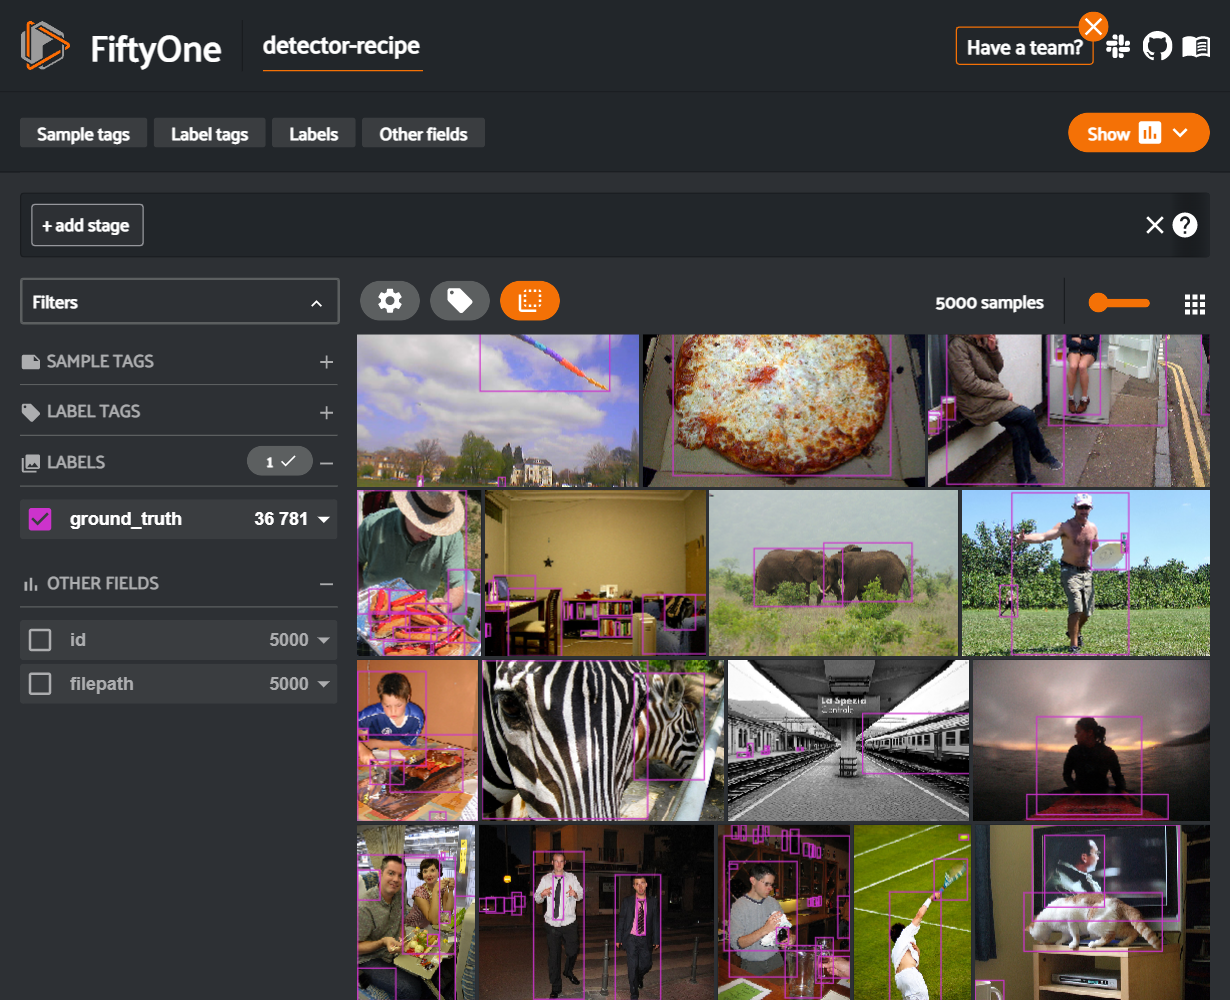

In [4]:
session = fo.launch_app(dataset)

In [5]:
import torch
import torchvision

# Run the model on GPU if it is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load a pre-trained Faster R-CNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.to(device)
model.eval()

print("Model ready")

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to C:\Users\01149762/.cache\torch\hub\checkpoints\fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100.0%


Model ready


In [6]:
# Choose a random subset of 100 samples to add predictions to
predictions_view = dataset.take(100, seed=51)

In [8]:
from PIL import Image
from torchvision.transforms import functional as func

import fiftyone as fo

# Get class list
classes = dataset.default_classes

# Add predictions to samples
with fo.ProgressBar() as pb:
    for sample in pb(predictions_view):
        # Load image
        image = Image.open(sample.filepath)
        image = func.to_tensor(image).to(device)
        c, h, w = image.shape

        # Perform inference
        preds = model([image])[0]
        labels = preds["labels"].cpu().detach().numpy()
        scores = preds["scores"].cpu().detach().numpy()
        boxes = preds["boxes"].cpu().detach().numpy()

        # Convert detections to FiftyOne format
        detections = []
        for label, score, box in zip(labels, scores, boxes):
            # Convert to [top-left-x, top-left-y, width, height]
            # in relative coordinates in [0, 1] x [0, 1]
            x1, y1, x2, y2 = box
            rel_box = [x1 / w, y1 / h, (x2 - x1) / w, (y2 - y1) / h]

            detections.append(
                fo.Detection(
                    label=classes[label],
                    bounding_box=rel_box,
                    confidence=score
                )
            )

        # Save predictions to dataset
        sample["predictions"] = fo.Detections(detections=detections)
        sample.save()

 100% |█████████████████| 100/100 [15.3s elapsed, 0s remaining, 6.7 samples/s]      


In [9]:
session.view = predictions_view
